
# **This notebook showcases future stock price prediction using recurrent neural networks (RNNs) with LSTM implemented in TensorFlow.**

**Outline:**

1. [Setup](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Setup <a class="anchor" id="1-bullet"></a> 

In [20]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- Please find the dataset [here](https://www.kaggle.com/datasets/dgawlik/nyse/data).
- Download the dataset then import the csv file as follows:

In [4]:
# import all stock prices 
df = pd.read_csv("<path_to_your_prices-split-adjusted.csv_file>", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['AAPL', 'ALLE', 'ILMN', 'PLD', 'COG', 'GIS', 'KORS', 'MMM', 'TMK', 'LLL']


In [6]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [7]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


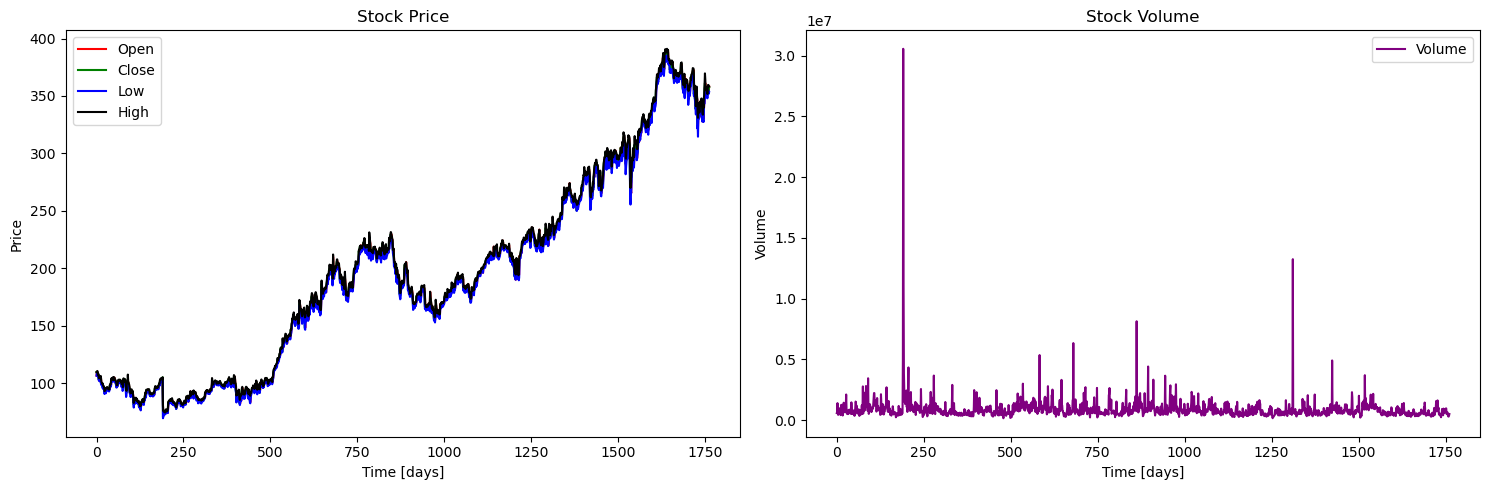

In [21]:
# Filter data for the selected stock symbol
eqix_data = df[df.symbol == 'EQIX']

# Create a figure with subplots
plt.figure(figsize=(15, 5))

# Plot stock prices
plt.subplot(1, 2, 1)
for column, color, label in zip(['open', 'close', 'low', 'high'], 
                                ['red', 'green', 'blue', 'black'], 
                                ['Open', 'Close', 'Low', 'High']):
    plt.plot(eqix_data[column].values, color=color, label=label)
plt.title('Stock Price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')

# Plot stock volume
plt.subplot(1, 2, 2)
plt.plot(eqix_data.volume.values, color='purple', label='Volume')  # Changed color for distinction
plt.title('Stock Volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

# Show the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 


In [19]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to normalize stock data
def normalize_data(df):
    scaler = MinMaxScaler()
    for column in ['open', 'high', 'low', 'close']:
        df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
    return df

# Function to split stock data into train, validation, and test sets
def load_data(stock_data, seq_len):
    data_raw = stock_data.values  # Convert to numpy array
    data = [data_raw[i: i + seq_len] for i in range(len(data_raw) - seq_len)]  # Sequences of length seq_len
    data = np.array(data)

    # Determine sizes of train, validation, and test sets
    valid_size = int(valid_set_size_percentage / 100 * data.shape[0])
    test_size = int(test_set_size_percentage / 100 * data.shape[0])
    train_size = data.shape[0] - (valid_size + test_size)

    # Split data
    x_train, y_train = data[:train_size, :-1, :], data[:train_size, -1, :]
    x_valid, y_valid = data[train_size:train_size + valid_size, :-1, :], data[train_size:train_size + valid_size, -1, :]
    x_test, y_test = data[train_size + valid_size:, :-1, :], data[train_size + valid_size:, -1, :]

    return x_train, y_train, x_valid, y_valid, x_test, y_test

# Select one stock and preprocess data
df_stock = df[df['symbol'] == 'EQIX'].copy()
df_stock.drop(columns=['symbol', 'volume'], inplace=True)

print('Columns in the dataset:', df_stock.columns.tolist())

# Normalize stock data
df_stock_normalized = normalize_data(df_stock)

# Create train, validation, and test datasets
seq_len = 20  # Length of each input sequence
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_normalized, seq_len)

# Display dataset shapes
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_valid shape: {x_valid.shape}')
print(f'y_valid shape: {y_valid.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')


Columns in the dataset: ['open', 'close', 'low', 'high']
x_train shape: (1394, 19, 4)
y_train shape: (1394, 4)
x_valid shape: (174, 19, 4)
y_valid shape: (174, 4)
x_test shape: (174, 19, 4)
y_test shape: (174, 4)


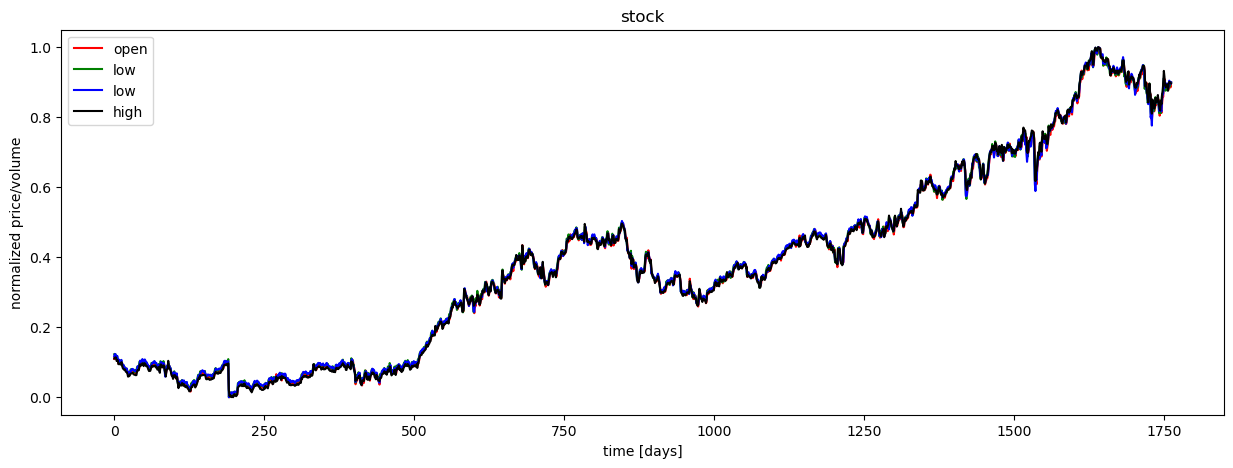

In [12]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 


In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.models import Model

# Data shuffling and batching
index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array
    start = index_in_epoch
    index_in_epoch += batch_size

    # Restart epoch if we reach the end
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array)
        start = 0
        index_in_epoch = batch_size

    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# Parameters
n_steps = seq_len - 1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100

# Model definition
inputs = Input(shape=(n_steps, n_inputs))
x = inputs
for _ in range(n_layers):
    x = LSTM(n_neurons, activation='elu', return_sequences=True)(x)
x = LSTM(n_neurons, activation='elu', return_sequences=False)(x)  # Last LSTM layer
outputs = Dense(n_outputs, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mse')

# Training
for epoch in range(n_epochs):
    for iteration in range(x_train.shape[0] // batch_size):
        x_batch, y_batch = get_next_batch(batch_size)
        model.train_on_batch(x_batch, y_batch)

    # Validation loss
    mse_train = model.evaluate(x_train, y_train, verbose=0)
    mse_valid = model.evaluate(x_valid, y_valid, verbose=0)
    print(f"Epoch {epoch + 1}/{n_epochs}: Train MSE={mse_train:.6f}, Valid MSE={mse_valid:.6f}")

# Predictions
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)
y_test_pred = model.predict(x_test)


Epoch 1/100: Train MSE=0.001930, Valid MSE=0.001907
Epoch 2/100: Train MSE=0.000675, Valid MSE=0.004834
Epoch 3/100: Train MSE=0.000517, Valid MSE=0.001798
Epoch 4/100: Train MSE=0.000497, Valid MSE=0.002295
Epoch 5/100: Train MSE=0.000434, Valid MSE=0.001347
Epoch 6/100: Train MSE=0.000422, Valid MSE=0.001327
Epoch 7/100: Train MSE=0.000411, Valid MSE=0.001260
Epoch 8/100: Train MSE=0.000408, Valid MSE=0.001231
Epoch 9/100: Train MSE=0.000392, Valid MSE=0.001199
Epoch 10/100: Train MSE=0.000414, Valid MSE=0.001356
Epoch 11/100: Train MSE=0.000403, Valid MSE=0.001313
Epoch 12/100: Train MSE=0.000448, Valid MSE=0.001423
Epoch 13/100: Train MSE=0.000358, Valid MSE=0.001135
Epoch 14/100: Train MSE=0.000343, Valid MSE=0.001099
Epoch 15/100: Train MSE=0.000330, Valid MSE=0.001071
Epoch 16/100: Train MSE=0.000322, Valid MSE=0.001108
Epoch 17/100: Train MSE=0.000331, Valid MSE=0.001237
Epoch 18/100: Train MSE=0.000316, Valid MSE=0.001094
Epoch 19/100: Train MSE=0.000303, Valid MSE=0.001027
Ep

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [16]:
y_train.shape

(1394, 4)

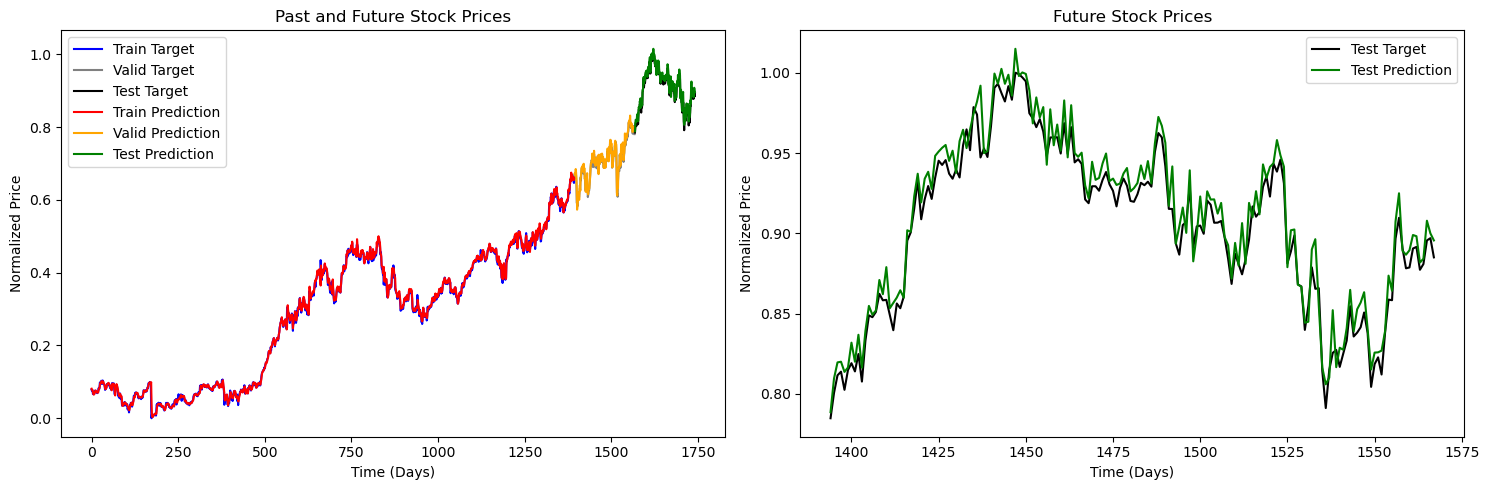

Correct sign prediction for close - open price (Train/Valid/Test): 0.75/0.64/0.61


In [18]:
# Feature index to plot (0 = open, 1 = close, 2 = highest, 3 = lowest)
ft = 0  

# Plot predictions vs actual values
plt.figure(figsize=(15, 5))

# Subplot 1: Past and future stock prices
plt.subplot(1, 2, 1)
plt.plot(y_train[:, ft], label='Train Target', color='blue')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_valid.shape[0]),
         y_valid[:, ft], label='Valid Target', color='gray')
plt.plot(range(y_train.shape[0] + y_valid.shape[0], y_train.shape[0] + y_valid.shape[0] + y_test.shape[0]),
         y_test[:, ft], label='Test Target', color='black')
plt.plot(y_train_pred[:, ft], label='Train Prediction', color='red')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_valid_pred.shape[0]),
         y_valid_pred[:, ft], label='Valid Prediction', color='orange')
plt.plot(range(y_train.shape[0] + y_valid_pred.shape[0], 
               y_train.shape[0] + y_valid_pred.shape[0] + y_test_pred.shape[0]),
         y_test_pred[:, ft], label='Test Prediction', color='green')

plt.title('Past and Future Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

# Subplot 2: Focus on test predictions
plt.subplot(1, 2, 2)
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
         y_test[:, ft], label='Test Target', color='black')
plt.plot(range(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
         y_test_pred[:, ft], label='Test Prediction', color='green')

plt.title('Future Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Calculate accuracy of predicting price direction (close - open)
def calculate_direction_accuracy(y_actual, y_pred):
    return np.mean(np.sign(y_actual[:, 1] - y_actual[:, 0]) == 
                   np.sign(y_pred[:, 1] - y_pred[:, 0]))

train_accuracy = calculate_direction_accuracy(y_train, y_train_pred)
valid_accuracy = calculate_direction_accuracy(y_valid, y_valid_pred)
test_accuracy = calculate_direction_accuracy(y_test, y_test_pred)

print(f"Correct sign prediction for close - open price (Train/Valid/Test): "
      f"{train_accuracy:.2f}/{valid_accuracy:.2f}/{test_accuracy:.2f}")
